# НАЧАЛО

Загрузка необходимых библиотек и модулей

In [ ]:
!pip install py_essentials
!pip install catalyst
!pip install efficientnet_pytorch

In [2]:
import os
import cv2
import statistics
import numpy as np
from scipy.stats import kurtosis, skew
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import PIL
from PIL import Image, ImageDraw
from py_essentials import hashing as hs
import seaborn as sns
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import f1_score 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pickle
from catalyst import utils
from efficientnet_pytorch import EfficientNet

print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)
print("Pillow Version: ", PIL.__version__)

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

SEED = 42
utils.set_global_seed(SEED)

PyTorch Version:  1.10.0+cu111
Torchvision Version:  0.11.1+cu111
Pillow Version:  7.1.2
CUDA is available!  Training on GPU ...


In [3]:
# Определяем на чем у нас будут производиться вычисления (cuda/cpu)
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')  
device

device(type='cuda', index=0)

In [4]:
!nvidia-smi

Fri Nov 12 11:59:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    29W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Подключение Google-диска

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Распаковка zip-архивов с изображениями (архивы подготовлены локально вручную для избежания мульти-вложенности)

In [ ]:
!unzip -q /content/drive/MyDrive/simpsons/train.zip -d train
!unzip -q /content/drive/MyDrive/simpsons/testset.zip -d test

## EDA

In [ ]:
BASE_DIR = Path('/content/drive/MyDrive/simpsons/')
TRAIN_DIR = Path('/content/train')
TEST_DIR = Path('/content/test')

Структура каталогов с изображениями

In [ ]:
total = 0
print('\033[1m' + 'TRAIN:')
print('\033[0m')

persons = []
count_persons = []

folders = ([name for name in os.listdir(TRAIN_DIR)
            if os.path.isdir(os.path.join(TRAIN_DIR, name))])
for folder in folders:
    contents = os.listdir(os.path.join(TRAIN_DIR, folder))
    print('   Персонаж:', folder, ', изображений:', len(contents))
    persons.append(folder)
    count_persons.append(len(contents))
    total += len(contents)

print('\nДиректория TRAIN содержит:', total, 'изображений с',
      len(os.listdir(TRAIN_DIR)), 'персонажами.\n')
print('\033[1m' + 'TEST:')
print('\033[0m')
print('Директория TEST содержит:', len(os.listdir(TEST_DIR)), 'изображение.')

TRAIN:

   Персонаж: rainier_wolfcastle , изображений: 45
   Персонаж: abraham_grampa_simpson , изображений: 913
   Персонаж: otto_mann , изображений: 32
   Персонаж: waylon_smithers , изображений: 181
   Персонаж: kent_brockman , изображений: 498
   Персонаж: moe_szyslak , изображений: 1452
   Персонаж: mayor_quimby , изображений: 246
   Персонаж: carl_carlson , изображений: 98
   Персонаж: apu_nahasapeemapetilon , изображений: 623
   Персонаж: charles_montgomery_burns , изображений: 1193
   Персонаж: krusty_the_clown , изображений: 1206
   Персонаж: agnes_skinner , изображений: 42
   Персонаж: cletus_spuckler , изображений: 47
   Персонаж: selma_bouvier , изображений: 103
   Персонаж: sideshow_bob , изображений: 877
   Персонаж: gil , изображений: 27
   Персонаж: milhouse_van_houten , изображений: 1079
   Персонаж: lisa_simpson , изображений: 1354
   Персонаж: homer_simpson , изображений: 2246
   Персонаж: lenny_leonard , изображений: 310
   Персонаж: patty_bouvier , изображений: 72


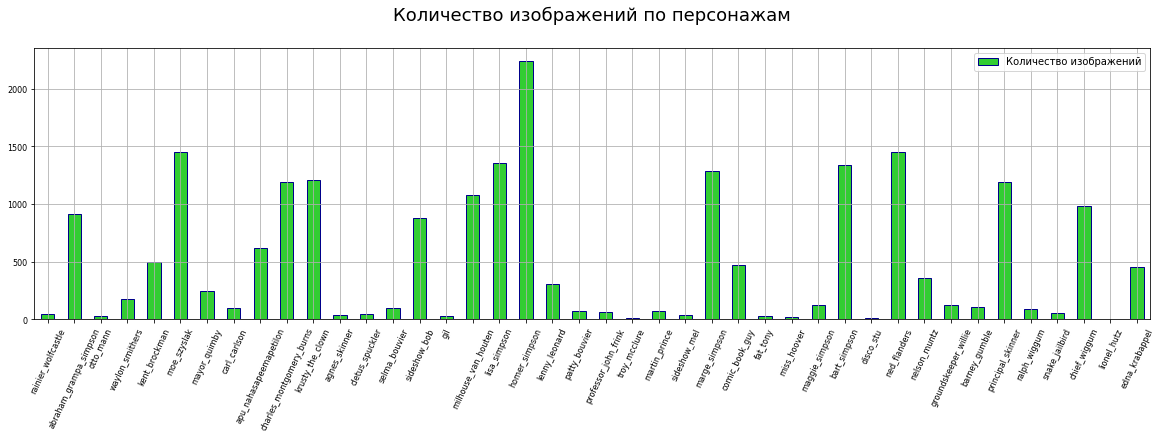

In [ ]:
df = pd.DataFrame(count_persons, persons)
df.columns = ['Количество изображений']
plot = df.plot.bar(
    figsize=(20, 5), fontsize=8, color='limegreen', 
    edgecolor='darkblue', linewidth=1, title='Количество изображений по персонажам\n')
plot.title.set_size(18)
plot.legend(loc=1, fontsize=10)
plot.set(ylabel=None, xlabel=None)
plot.grid()
plt.xticks(rotation=65)
plt.show()

#### Характеристики представленных изображений набора TRAIN и статистика по ним

In [ ]:
idx = 0
size_images = dict()
for folder in folders:
    folder_images = TRAIN_DIR/folder
    for dirpath, _, filenames in os.walk(folder_images):
        for path_image in filenames:
            image = os.path.abspath(os.path.join(dirpath, path_image))
            with Image.open(image) as img:
                weight = os.path.getsize(image)
                width, heigth = img.size
                hash_object = hs.fileChecksum(image, "sha256")
                size_images[idx] = {'weight': weight,
                                    'width': width,
                                    'heigth': heigth,
                                    'persons': folder,
                                    'filename': path_image,
                                    'hash': hash_object}
                idx += 1
df_train = pd.DataFrame(size_images).T
df_train = df_train.astype({'width': int, 'heigth': int})
df_train['notsquare'] = abs(df_train['heigth'] - df_train['width'])
df_train['image_path'] = df_train['persons'] + str('/') + df_train['filename']
df_train['full_path'] = str(TRAIN_DIR) + str('/') + df_train['image_path']

Базовые метрики размеров изображений набора TRAIN:
count    20933.000000
mean       416.877562
std         62.214658
min        256.000000
25%        379.000000
50%        432.000000
75%        480.000000
max       1072.000000
Name: heigth, dtype: float64
------------------------------------
Самые популярные значения метрики, топ 5
480    5163
432    4918
416    2972
352    2647
256    1000
Name: heigth, dtype: int64
------------------------------------


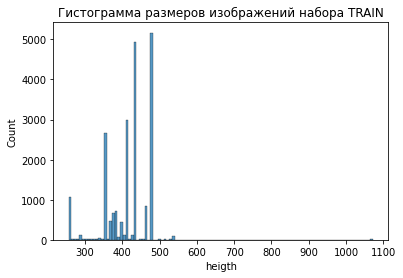

In [ ]:
sns.histplot(df_train['heigth'])
plt.title('Гистограмма размеров изображений набора TRAIN')

print("Базовые метрики размеров изображений набора TRAIN:")
print(df_train['heigth'].describe())
print("------------------------------------")

print("Самые популярные значения метрики, топ 5")
print(df_train['heigth'].value_counts().nlargest(5))
print("------------------------------------")

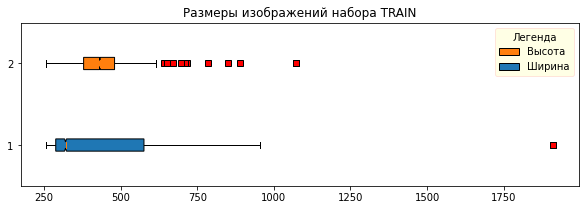

In [ ]:
red_square = dict(markerfacecolor='r', marker='s')
fig1, ax1 = plt.subplots(figsize=(10, 3))
ax1.set_title('Размеры изображений набора TRAIN')
bp1 = ax1.boxplot(df_train.width, positions=[1], vert=False, flierprops=red_square, notch=True,
                  patch_artist=True, boxprops=dict(facecolor="C0"))
bp2 = ax1.boxplot(df_train.heigth, positions=[2], vert=False, flierprops=red_square, notch=True,
                  patch_artist=True, boxprops=dict(facecolor="C1"))
ax1.legend([bp2['boxes'][0], bp1['boxes'][0]],
           ['Высота', 'Ширина'], loc='upper right',
           facecolor='yellow', edgecolor='r', framealpha=.1, title='Легенда')
plt.show()

Оценим визуально несколько изображений с наибольшими размерами

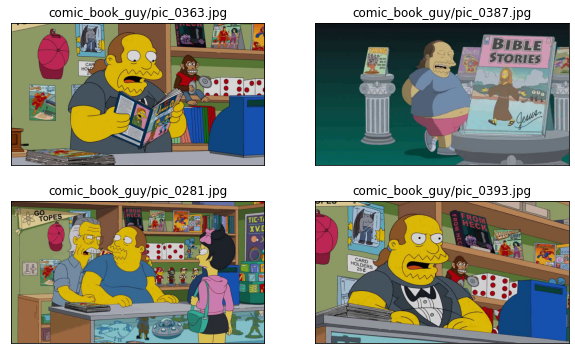

In [ ]:
image_list = df_train.sort_values('weight', ascending=False)[
    'filename'].head(4).tolist()
persons_list = df_train.sort_values('weight', ascending=False)[
    'persons'].head(4).tolist()
plt.figure(figsize=(10, 6))

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.title(persons_list[i] + str('/') + image_list[i])
    plt.grid(False)
    image_path = str(TRAIN_DIR) + str('/') + \
        str(persons_list[i]) + str('/') + str(image_list[i])
    img = mpimg.imread(image_path)
    plt.imshow(img, cmap=plt.cm.gray)

In [ ]:
# есть смысл избавиться от нескольких выбросов
df_train[(df_train['width'] >= 1000) & (df_train['heigth'] >= 1000)]

,weight,width,heigth,persons,filename,hash,notsquare,image_path
14222,238676,1912,1072,comic_book_guy,pic_0387.jpg,e7088aeb8cbf56e9de2357845a004e494a28f9aa1d3ad8...,840,comic_book_guy/pic_0387.jpg
14499,270401,1912,1072,comic_book_guy,pic_0363.jpg,848929b62e0c971a23a129d70a690c1432f75d4135f314...,840,comic_book_guy/pic_0363.jpg


In [ ]:
df_train = df_train[(df_train['width'] <= 1900)]
df_train.to_csv(BASE_DIR/'df_train.csv', sep=',', index_label='index')

---

Проведем исследование TRAIN-датасета на предмет яркости изображений и выведем наиболее затемненные/светлые фотографии


За пределы 3-х сигм выходит: 278 значений освещенности.

Базовые метрики освещенности
count    20933.000000
mean       103.429646
std         27.357468
min         17.471634
25%         85.615605
50%        102.938438
75%        119.402381
max        248.505893
Name: lvalueld, dtype: float64
------------------------------------
Самые популярные значения метрики освещенности, топ 5
100.923173    2
114.515255    2
100.149177    2
105.985155    2
67.038671     2
Name: lvalueld, dtype: int64
------------------------------------
Эксцесс  1.7745217771813753
Ассиметрия  0.6192852331142814 



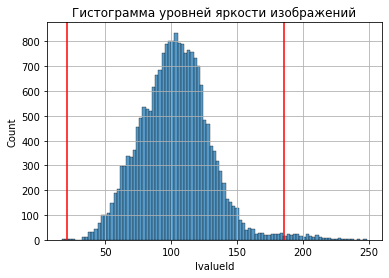

In [ ]:
lvalueld_list = []
for idx, row in df_train.iterrows():
    image_path = str(TRAIN_DIR) + str('/') + row[3] + str('/') + row[4]
    image = cv2.imread(image_path)
    hsld = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    Lchanneld = hsld[:, :, 1]
    lvalueld = cv2.mean(Lchanneld)[0]
    lvalueld_list.append(lvalueld)
df_train = df_train.assign(lvalueld=lvalueld_list).sort_values(
    'lvalueld', ascending=True)

upper_level = df_train.lvalueld.mean() + 3*df_train.lvalueld.std()
lower_level = df_train.lvalueld.mean() - 3*df_train.lvalueld.std()
sns.histplot(df_train.lvalueld)
plt.axvline(x=lower_level, color="r", linestyle="-")
plt.axvline(x=upper_level, color="r", linestyle="-")
plt.title('Гистограмма уровней яркости изображений')
plt.grid()
print('\nЗа пределы 3-х сигм выходит:',
      df_train[(df_train['lvalueld'] < lower_level) | (df_train['lvalueld'] > upper_level)]['lvalueld'].count(), 'значений освещенности.\n')
print("Базовые метрики освещенности")
print(df_train.lvalueld.describe())
print("------------------------------------")

print("Самые популярные значения метрики освещенности, топ 5")
print(df_train.lvalueld.value_counts().nlargest(5))
print("------------------------------------")

print("Эксцесс ", kurtosis(df_train.lvalueld))
print("Ассиметрия ", skew(df_train.lvalueld), '\n')

# сохраним полученный датафрейм в csv-файл
df_train.to_csv(BASE_DIR/'df_train.csv', sep=',', index_label='index')

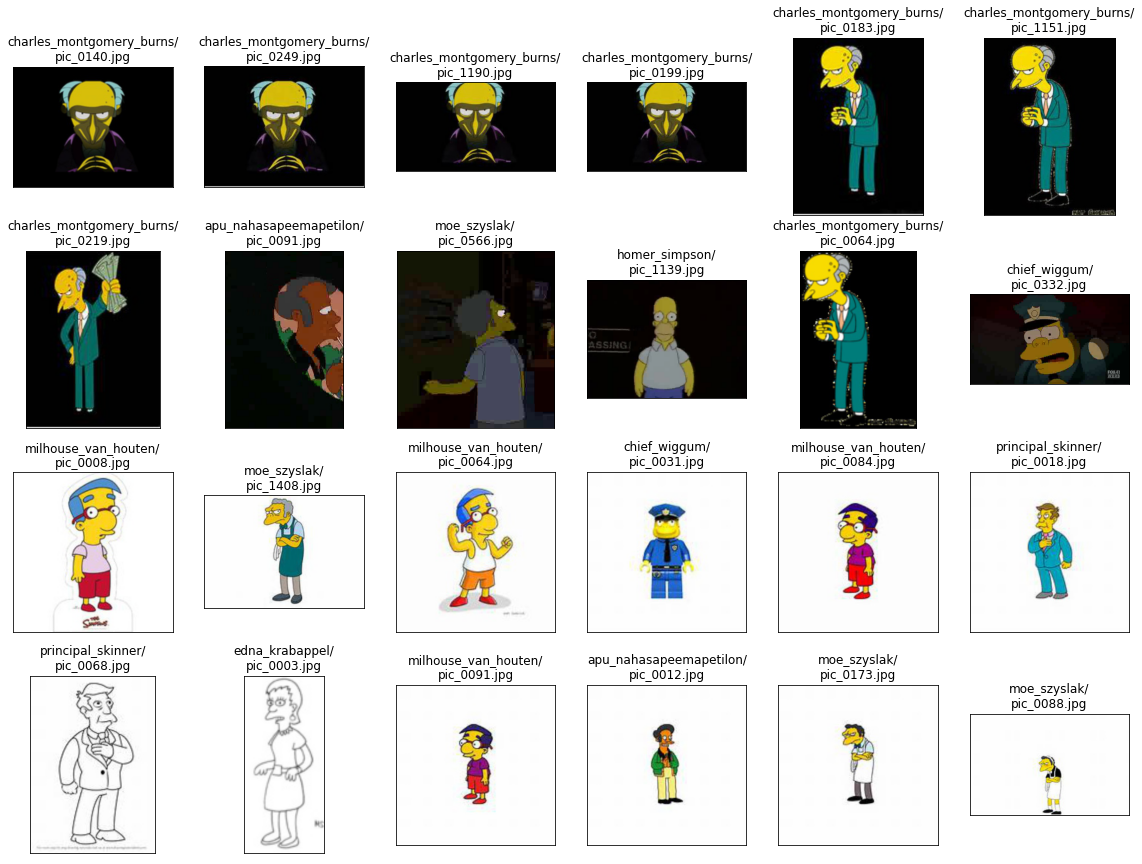

In [ ]:
# визуально оценим различия самой темной группы изображений от самой светлой
dark_light = [i for i in range(0, 12)]
dark_light.extend(
    [i for i in range(df_train.shape[0] - 12, df_train.shape[0])])
j = 0
plt.figure(figsize=(20, 15))

for i in dark_light:
    plt.subplot(4, 6, j+1)
    image_path = str(TRAIN_DIR) + str('/') + \
        df_train.iloc[i][3] + str('/') + df_train.iloc[i][4]
    plt.title(df_train.iloc[i][3] + str('/\n') + df_train.iloc[i][4])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = mpimg.imread(image_path)
    plt.imshow(img, cmap=plt.cm.gray)
    j += 1

---

Проверим наличие одинаковых фотографий, отнесенных к разным категориям (ТАКОЕ ТОЖЕ БЫВАЕТ ! )

In [ ]:
person = []
hash_list = df_train[df_train.duplicated(subset=['hash'], keep='first')]['hash'].tolist()
for hash in hash_list:
    for _, row in df_train.iterrows():
        if row[5] == hash:
            person.append(row[3])
    assert len(set(person)) == 1, 'Найдены одинаковые изображения в разных категориях'
    person = []
print('Одинаковых изображений, отнесенных к разным категориям не обнаружено')

Одинаковых изображений, отнесенных к разным категориям не обнаружено


# Выводы по EDA
1. Представленный датасет сильно не сбалансирован по количеству изображений в категориях (от минимальных 3-х изображений до максимальных 2246). Предстоит осуществить балансировку датасета путем семплирования с аугментацией.
2. Размеры изображений изменяются в диапазоне от 256 px до 1912 px по ширине, и от 256 px до 1072 px по высоте.
3. Контраст/освещенность изображений на приемлемом уровне.
4. Дублирование одинаковыми изображениями в разных категориях не выявлено.
5. Применение различных face-детекторов (DNN, MTCNN) не дало значимых результатов в части выявления изображений с "шумом", фрагментированных, содержащих 2 и более лиц (и оставлено за рамками данной работы как малозначимое). Однако, в датасете присутствует явный мульти-боксинг (множественные лица на одном фото), фрагментированные, зашумленные изображения в неопределенном количестве.
6. Как правило, на изображении персонаж заданного класса расположен примерно по центру.


# Подготовка среды, dataloader-ов, семплирование, аугментация, нормализация

In [ ]:
df_train = pd.read_csv(BASE_DIR/'df_train.csv', sep=',', index_col='index')

In [ ]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']

In [ ]:
# Паддинг изображения
class SquarePad:
    def __call__(self, image):
        w, h = image.size
        max_wh = np.max([w, h])
        hp = int((max_wh - w) / 2)
        vp = int((max_wh - h) / 2)
        padding = (hp, vp, hp, vp)
        return F.pad(image, padding, 0, 'edge')

In [ ]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """

    def __init__(self, files, mode, rescale_size):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode
        self.rescale_size = rescale_size

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        if self.mode != 'train':
            transform = transforms.Compose([
                transforms.Resize(size=(self.rescale_size, self.rescale_size)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [
                                     0.229, 0.224, 0.225])
            ])
            x = self.load_sample(self.files[index])
            x = transform(x)
        else:
            transform = transforms.Compose([
                SquarePad(),  # pading
                transforms.Resize(size=(self.rescale_size, self.rescale_size)),
                transforms.CenterCrop(self.rescale_size * .9),
                transforms.RandomRotation(2.8),
                transforms.RandomChoice([
                    transforms.RandomHorizontalFlip(p=0.5),
                    # transforms.RandomPosterize(bits=2),
                    # transforms.RandomSolarize(threshold=192.0),
                    #transforms.RandomAdjustSharpness(.9, p=0.5),
                    transforms.ColorJitter(
                                        brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
                    transforms.RandomApply([transforms.RandomHorizontalFlip(
                        p=1), transforms.ColorJitter(contrast=0.9)], p=0.5),
                    transforms.RandomApply([transforms.RandomHorizontalFlip(
                        p=1), transforms.ColorJitter(brightness=0.1)], p=0.5),
                ]),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [
                                     0.229, 0.224, 0.225])
            ])
            x = self.load_sample(self.files[index])
            x = transform(x)

        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
path_list = []
train_val_files = sorted(df_train['full_path'].tolist())
for elem in train_val_files:
    path_list.append(Path(elem))
train_val_files = path_list

test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25,
                                          stratify=train_val_labels)

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val', rescale_size=224)
train_dataset = SimpsonsDataset(train_files, mode='train', rescale_size=224)

Давайте посмотрим на наших аугментированных героев внутри датасета.
Выбран наименьший класс с 2-мя изначальными изображениями в TRAIN-датасете.

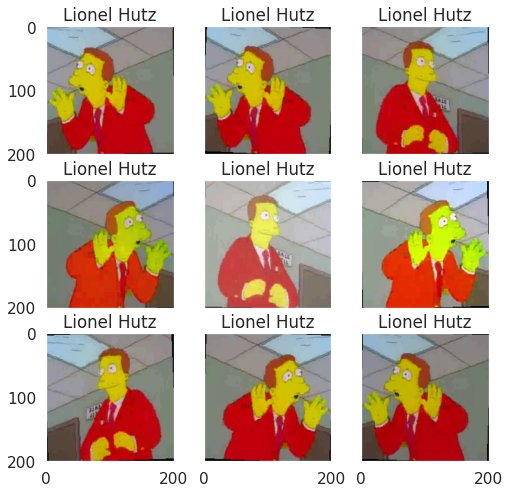

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(8, 8),
                       sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(8038, 8040))
    im_train, label = train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),
                             train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_train.data.cpu(),
           title=img_label, plt_ax=fig_x)

# OverSampling (по мотивам комментариев на Stepik-e)

In [ ]:
train_labels = [path.parent.name for path in train_files]  # классы train
val_labels = [path.parent.name for path in val_files]     # классы val

In [ ]:
def create_dct_path_labels(train_files, train_labels):
    dct_simpsons = {}
    for label_i in np.unique(train_labels).tolist():
        dct_simpsons[label_i] = []

    for path_i, label_i in zip(train_files, train_labels):
        dct_simpsons[label_i].append(path_i)

    return dct_simpsons


def print_dct(dct_simpsons):
    for key in dct_simpsons:
        print(f"{key}\t{dct_simpsons[key]}")

In [ ]:
# Создадим словарь в котором ключами будут персонажи Симпсонов, а значениями списки с путями к картинкам.
dct_path_train = create_dct_path_labels(train_files, train_labels)

In [ ]:
# Дополним картинки классов у которых менее 100 картинок, до 100 картинок в классе
for person in dct_path_train:
    if len(dct_path_train[person]) < 100:
        dct_path_train[person] = dct_path_train[person] * \
            (100 // len(dct_path_train[person]))
        dct_path_train[person].extend(
            dct_path_train[person][:100 - len(dct_path_train[person])])

In [ ]:
def create_dct_from_labels(train_val_labels):
    """Функция создает из list train_val_labels, содержащего метки классов
    соответсвующим картинкам из выборки, словарь dict с ключами соответсвующими
    названиям классов, и значениями, соответвующими колчеству этих классов в 
    list train_val_labels"""
    dct_simpsons = {}
    for label_i in np.unique(train_val_labels).tolist():
        dct_simpsons.update({label_i: train_val_labels.count(label_i)})

    return dct_simpsons

In [ ]:
new_train_files = []

for person in dct_path_train:
    new_train_files.extend(dct_path_train[person])

new_train_label = [
    path.parent.name for path in new_train_files]  # классы train

# выведим на печать класс:количество картинок для train должно быть примерно 75 %
print_dct(create_dct_from_labels(new_train_label))

abraham_grampa_simpson	685
agnes_skinner	100
apu_nahasapeemapetilon	467
barney_gumble	100
bart_simpson	1006
carl_carlson	100
charles_montgomery_burns	895
chief_wiggum	739
cletus_spuckler	100
comic_book_guy	350
disco_stu	100
edna_krabappel	343
fat_tony	100
gil	100
groundskeeper_willie	100
homer_simpson	1684
kent_brockman	374
krusty_the_clown	904
lenny_leonard	233
lionel_hutz	100
lisa_simpson	1015
maggie_simpson	100
marge_simpson	968
martin_prince	100
mayor_quimby	185
milhouse_van_houten	809
miss_hoover	100
moe_szyslak	1089
ned_flanders	1090
nelson_muntz	269
otto_mann	100
patty_bouvier	100
principal_skinner	895
professor_john_frink	100
rainier_wolfcastle	100
ralph_wiggum	100
selma_bouvier	100
sideshow_bob	658
sideshow_mel	100
snake_jailbird	100
troy_mcclure	100
waylon_smithers	136


График наполненности категорий после семплирования до требуемого минимума = 100

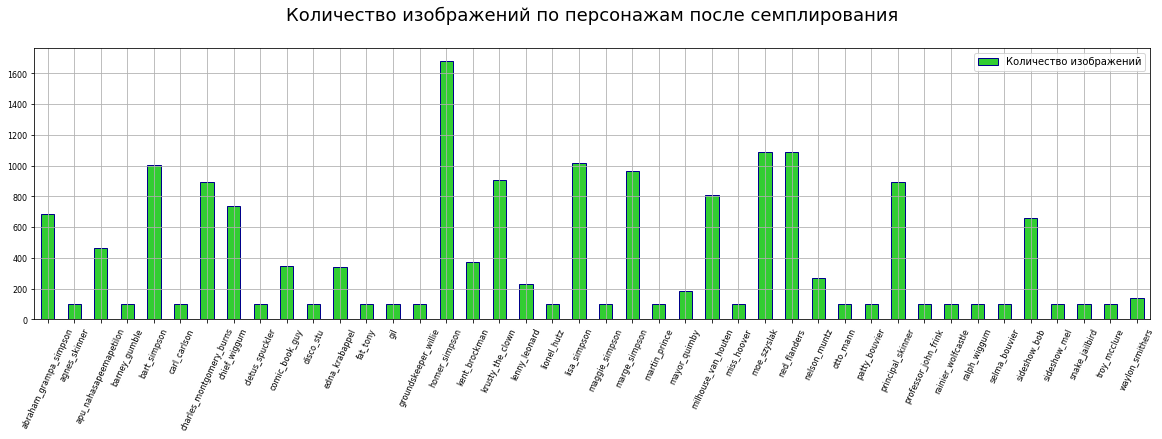

In [ ]:
df = pd.DataFrame(list(create_dct_from_labels(new_train_label).values()),
                  list(create_dct_from_labels(new_train_label).keys()))
df.columns = ['Количество изображений']
plot = df.plot.bar(
    figsize=(20, 5), fontsize=8, color='limegreen', edgecolor='darkblue', linewidth=1, 
    title='Количество изображений по персонажам после семплирования\n')
plot.title.set_size(18)
plot.legend(loc=1, fontsize=10)
plot.set(ylabel=None, xlabel=None)
plot.grid()
plt.xticks(rotation=65)
plt.show()

# Выбор типов CNN-сетей, transfer-learning, обучение

### Отключение вычисления градиента

In [ ]:
# feature_extracting = False - вычисляем градиент у всей сети (обучаем всю модель)
# feature_extracting = True - обучаем только FC
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

### Модели (инициализация, обучение, подбор параметров, etc...)

In [ ]:
def initialize_model(model_name, feature_extract, use_pretrained=True):

    model_ft = None
    # Количество классов в датасете
    num_classes = len(os.listdir(TRAIN_DIR))

    if model_name == 'efficientnet-b0':
        """ efficientnet-b0
        """
        model_ft = EfficientNet.from_pretrained('efficientnet-b0')
        # отключает обновление градиентов у замороженных слоев
        set_parameter_requires_grad(model_ft, feature_extract)
        # получаем кол-во нейронов входящих в последний слой
        num_ftrs = model_ft._fc.in_features
        # меняем последний слой _fc на наш код
        model_ft._fc = nn.Sequential(
            nn.Linear(in_features=num_ftrs, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=num_classes)
        )

    elif model_name == 'efficientnet-b1':
        """ efficientnet-b1
        """
        model_ft = EfficientNet.from_pretrained('efficientnet-b1')
        # отключает обновление градиентов у замороженных слоев
        set_parameter_requires_grad(model_ft, feature_extract)
        # получаем кол-во нейронов входящих в последний слой
        num_ftrs = model_ft._fc.in_features
        # меняем последний слой _fc на наш код
        model_ft._fc = nn.Sequential(
            nn.Linear(in_features=num_ftrs, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=num_classes)
        )

    elif model_name == 'efficientnet-b2':
        """ efficientnet-b2
        """
        model_ft = EfficientNet.from_pretrained('efficientnet-b2')
        # отключает обновление градиентов у замороженных слоев
        set_parameter_requires_grad(model_ft, feature_extract)
        # получаем кол-во нейронов входящих в последний слой
        num_ftrs = model_ft._fc.in_features
        # меняем последний слой _fc на наш код
        model_ft._fc = nn.Sequential(
            nn.Linear(in_features=num_ftrs, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=num_classes)
        )

    elif model_name == 'efficientnet-b3':
        """ efficientnet-b3
        """
        model_ft = EfficientNet.from_pretrained('efficientnet-b3')
        # отключает обновление градиентов у замороженных слоев
        set_parameter_requires_grad(model_ft, feature_extract)
        # получаем кол-во нейронов входящих в последний слой
        num_ftrs = model_ft._fc.in_features
        # меняем последний слой _fc на наш код
        model_ft._fc = nn.Sequential(
            nn.Linear(in_features=num_ftrs, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=num_classes)
        )

    elif model_name == 'efficientnet-b4':
        """ efficientnet-b4
        """
        model_ft = EfficientNet.from_pretrained('efficientnet-b4')
        # отключает обновление градиентов у замороженных слоев
        set_parameter_requires_grad(model_ft, feature_extract)
        # получаем кол-во нейронов входящих в последний слой
        num_ftrs = model_ft._fc.in_features
        # меняем последний слой _fc на наш код
        model_ft._fc = nn.Sequential(
            nn.Linear(in_features=num_ftrs, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=num_classes)
        )

    elif model_name == 'resnet152':
        """ resnet152
        """
        model_ft = models.resnet152(pretrained=use_pretrained)
        # отключает обновление градиентов у замороженных слоев
        set_parameter_requires_grad(model_ft, feature_extract)
        # получаем кол-во нейронов входящих в последний слой
        num_ftrs = model_ft.fc.in_features
        # меняем последний слой _fc на наш код
        model_ft.fc = nn.Linear(num_ftrs, num_classes)

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft

### Обучение

In [ ]:
def model_learning(model_name, model_ft, rescale_size, batch_size):

    val_dataset = SimpsonsDataset(
        val_files, mode='val', rescale_size=rescale_size)
    new_train_dataset = SimpsonsDataset(
        new_train_files, mode='train', rescale_size=rescale_size)

    dataloaders = {'train': DataLoader(new_train_dataset, batch_size=batch_size, shuffle=True, num_workers=2),
                   'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)}
    dataset_sizes = {'train': len(new_train_dataset), 'val': len(val_dataset)}

    # Базовая скорость обучения
    base_lr = 1e-3

    # Количество эпох
    num_epochs = 10

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model_ft.parameters(), lr=base_lr, betas=(
        0.0, 0.999), eps=1e-8, weight_decay=0, amsgrad=True)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(
        optimizer, milestones=[2, 4, 6, 8], gamma=0.8)

    accuracy = {"train": [], "val": []}

    for epoch in range(num_epochs):
        for k, dataloader in dataloaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                if k == "train":
                    model_ft.train()
                    optimizer.zero_grad()
                    outp = model_ft(x_batch)
                else:
                    model_ft.eval()
                    with torch.no_grad():
                        outp = model_ft(x_batch)
                preds = outp.argmax(-1)
                correct = (preds.detach() == y_batch).sum(dim=0)
                all = y_batch.size(0)
                epoch_correct += correct.item()
                epoch_all += all
                if k == "train":
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    optimizer.step()
            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)
        scheduler.step()
    row = {'model': model_name, 'Acc_train': round(
        max(accuracy['train']), 3), 'Acc_val': round(max(accuracy['val']), 3)}
    torch.save(model_ft.state_dict(), Path(
        str(BASE_DIR) + str('/') + str(model_name)))

    # очистка кеша
    del model_ft
    del x_batch
    del y_batch
    torch.cuda.empty_cache()

    return(accuracy, row)

In [ ]:
# сбор статистики
df_model = pd.DataFrame()
df_accuracy = pd.DataFrame()

In [159]:
# Памятка: feature_extract - обучаем только последние добавленные нами FC-слои (True) или обучаем всю модель (False)

In [ ]:
model_name = 'efficientnet-b0'

accuracy_b0, row_b0 = model_learning(model_name,
                                     initialize_model(model_name,
                                                      feature_extract=False,
                                                      use_pretrained=True).to(device),
                                     rescale_size=EfficientNet.get_image_size(model_name), batch_size=128)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b0
Epoch: 1
Loader: train. Accuracy: 0.8269799928968865
Loader: val. Accuracy: 0.9398050831263137
Epoch: 2
Loader: train. Accuracy: 0.9606961051260803
Loader: val. Accuracy: 0.9527995413720619
Epoch: 3
Loader: train. Accuracy: 0.9807624008523737
Loader: val. Accuracy: 0.9541372061914771
Epoch: 4
Loader: train. Accuracy: 0.9838404167159939
Loader: val. Accuracy: 0.9547104911140837
Epoch: 5
Loader: train. Accuracy: 0.9911211080857109
Loader: val. Accuracy: 0.9677049493598319
Epoch: 6
Loader: train. Accuracy: 0.9923641529537114
Loader: val. Accuracy: 0.9652207146952035
Epoch: 7
Loader: train. Accuracy: 0.9957381318811412
Loader: val. Accuracy: 0.9734377985858972
Epoch: 8
Loader: train. Accuracy: 0.9957973244939031
Loader: val. Accuracy: 0.969998089050258
Epoch: 9
Loader: train. Accuracy: 0.9973955250384752
Loader: val. Accuracy: 0.9766864131473342
Epoch: 10
Loader: train. Accuracy: 0.9976914881022848
Loader: val. Accuracy: 0.9740110835085037


In [ ]:
model_name = 'efficientnet-b1'

accuracy_b1, row_b1 = model_learning(model_name,
                                     initialize_model(model_name,
                                                      feature_extract=False,
                                                      use_pretrained=True).to(device),
                                     rescale_size=EfficientNet.get_image_size(model_name), batch_size=128)

Loaded pretrained weights for efficientnet-b1
Epoch: 1
Loader: train. Accuracy: 0.8361548478749852
Loader: val. Accuracy: 0.9398050831263137
Epoch: 2
Loader: train. Accuracy: 0.9642476618917959
Loader: val. Accuracy: 0.9562392509077011
Epoch: 3
Loader: train. Accuracy: 0.981235941754469
Loader: val. Accuracy: 0.9640741448499904
Epoch: 4
Loader: train. Accuracy: 0.9862673138392328
Loader: val. Accuracy: 0.9654118096694057
Epoch: 5
Loader: train. Accuracy: 0.991831419438854
Loader: val. Accuracy: 0.9701891840244602
Epoch: 6
Loader: train. Accuracy: 0.9929560790813307
Loader: val. Accuracy: 0.9730556086374929
Epoch: 7
Loader: train. Accuracy: 0.9949686279152362
Loader: val. Accuracy: 0.9743932734569081
Epoch: 8
Loader: train. Accuracy: 0.9955013614300935
Loader: val. Accuracy: 0.9770686030957386
Epoch: 9
Loader: train. Accuracy: 0.9970995619746655
Loader: val. Accuracy: 0.9801261226829734
Epoch: 10
Loader: train. Accuracy: 0.9972771398129513
Loader: val. Accuracy: 0.9837569271928148


In [ ]:
model_name = 'efficientnet-b2'

accuracy_b2, row_b2 = model_learning(model_name,
                                     initialize_model(model_name,
                                                      feature_extract=False,
                                                      use_pretrained=True).to(device),
                                     rescale_size=EfficientNet.get_image_size(model_name), batch_size=64)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b2-8bb594d6.pth


  0%|          | 0.00/35.1M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b2
Epoch: 1
Loader: train. Accuracy: 0.8446785841127027
Loader: val. Accuracy: 0.9237531052933308
Epoch: 2
Loader: train. Accuracy: 0.9557239256540784
Loader: val. Accuracy: 0.9526084463978597
Epoch: 3
Loader: train. Accuracy: 0.9785722741801823
Loader: val. Accuracy: 0.9688515192050449
Epoch: 4
Loader: train. Accuracy: 0.9797561264354209
Loader: val. Accuracy: 0.9654118096694057
Epoch: 5
Loader: train. Accuracy: 0.991831419438854
Loader: val. Accuracy: 0.9602522453659469
Epoch: 6
Loader: train. Accuracy: 0.9911803006984728
Loader: val. Accuracy: 0.9659850945920122
Epoch: 7
Loader: train. Accuracy: 0.9945542796259027
Loader: val. Accuracy: 0.9797439327345691
Epoch: 8
Loader: train. Accuracy: 0.9961524801704748
Loader: val. Accuracy: 0.9778329829925473
Epoch: 9
Loader: train. Accuracy: 0.9974547176512372
Loader: val. Accuracy: 0.9808905025797822
Epoch: 10
Loader: train. Accuracy: 0.9986977625192376
Loader: val. Accuracy: 0.9816548824765908


In [ ]:
model_name = 'efficientnet-b3'

accuracy_b3, row_b3 = model_learning(model_name,
                                     initialize_model(model_name,
                                                      feature_extract=False,
                                                      use_pretrained=True).to(device),
                                     rescale_size=EfficientNet.get_image_size(model_name), batch_size=32)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth


  0%|          | 0.00/47.1M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b3
Epoch: 1
Loader: train. Accuracy: 0.8309458979519356
Loader: val. Accuracy: 0.9203133957576916
Epoch: 2
Loader: train. Accuracy: 0.9390316088552149
Loader: val. Accuracy: 0.9308236193388114
Epoch: 3
Loader: train. Accuracy: 0.9708772345211317
Loader: val. Accuracy: 0.9698069940760558
Epoch: 4
Loader: train. Accuracy: 0.9813543269799929
Loader: val. Accuracy: 0.9591056755207338
Epoch: 5
Loader: train. Accuracy: 0.9892269444773293
Loader: val. Accuracy: 0.9740110835085037
Epoch: 6
Loader: train. Accuracy: 0.9908843376346632
Loader: val. Accuracy: 0.9814637875023887
Epoch: 7
Loader: train. Accuracy: 0.9963300580087605
Loader: val. Accuracy: 0.9780240779667495
Epoch: 8
Loader: train. Accuracy: 0.9966260210725701
Loader: val. Accuracy: 0.9805083126313778
Epoch: 9
Loader: train. Accuracy: 0.9969219841363798
Loader: val. Accuracy: 0.9820370724249953
Epoch: 10
Loader: train. Accuracy: 0.9982242216171422
Loader: val. Accuracy: 0.9833747372444105


In [ ]:
model_name = 'efficientnet-b4'

accuracy_b4, row_b4 = model_learning(model_name,
                                     initialize_model(model_name,
                                                      feature_extract=False,
                                                      use_pretrained=True).to(device),
                                     rescale_size=EfficientNet.get_image_size(model_name), batch_size=16)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth


  0%|          | 0.00/74.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b4
Epoch: 1
Loader: train. Accuracy: 0.8070912750088789
Loader: val. Accuracy: 0.8956621440856105
Epoch: 2
Loader: train. Accuracy: 0.9268971232390197
Loader: val. Accuracy: 0.9520351614752532
Epoch: 3
Loader: train. Accuracy: 0.9673256777554161
Loader: val. Accuracy: 0.969998089050258
Epoch: 4
Loader: train. Accuracy: 0.9790458150822777
Loader: val. Accuracy: 0.973246703611695
Epoch: 5
Loader: train. Accuracy: 0.9860897360009471
Loader: val. Accuracy: 0.9808905025797822
Epoch: 6
Loader: train. Accuracy: 0.9911211080857109
Loader: val. Accuracy: 0.9826103573476017
Epoch: 7
Loader: train. Accuracy: 0.9946134722386646
Loader: val. Accuracy: 0.9841391171412192
Epoch: 8
Loader: train. Accuracy: 0.9958565171066651
Loader: val. Accuracy: 0.9805083126313778
Epoch: 9
Loader: train. Accuracy: 0.9977506807150468
Loader: val. Accuracy: 0.9847124020638257
Epoch: 10
Loader: train. Accuracy: 0.9981650290043802
Loader: val. Accuracy: 0.9845213070896235


In [ ]:
model_name = 'resnet152'

accuracy_r152, row_r152 = model_learning(model_name,
                                         initialize_model(model_name,
                                                          feature_extract=False,
                                                          use_pretrained=True).to(device),
                                         rescale_size=224, batch_size=64)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

Epoch: 1
Loader: train. Accuracy: 0.5603172724044039
Loader: val. Accuracy: 0.8322186126504872
Epoch: 2
Loader: train. Accuracy: 0.8368651592281283
Loader: val. Accuracy: 0.8557232944773553
Epoch: 3
Loader: train. Accuracy: 0.9179590387119687
Loader: val. Accuracy: 0.8157844448691
Epoch: 4
Loader: train. Accuracy: 0.9369598674085474
Loader: val. Accuracy: 0.9199312058092872
Epoch: 5
Loader: train. Accuracy: 0.9596898307091275
Loader: val. Accuracy: 0.9096120772023696
Epoch: 6
Loader: train. Accuracy: 0.9686871078489404
Loader: val. Accuracy: 0.9340722339002484
Epoch: 7
Loader: train. Accuracy: 0.9809991713034213
Loader: val. Accuracy: 0.9503153067074336
Epoch: 8
Loader: train. Accuracy: 0.9854978098733278
Loader: val. Accuracy: 0.9566214408561055
Epoch: 9
Loader: train. Accuracy: 0.9889901740262815
Loader: val. Accuracy: 0.9648385247467992
Epoch: 10
Loader: train. Accuracy: 0.9942583165620931
Loader: val. Accuracy: 0.9623542900821709


In [ ]:
# Сохранение статистик
for row in [row_b0, row_b1, row_b2, row_b3, row_b4, row_r152]:
    df_model = df_model.append(row, ignore_index=True)

for accuracy in [accuracy_b0, accuracy_b1, accuracy_b2, accuracy_b3, accuracy_b4, accuracy_r152]:
    df_accuracy = df_accuracy.append(accuracy, ignore_index=True)

df_model.to_csv(BASE_DIR/'df_model.csv', sep=',', index_label='index')
df_accuracy.to_csv(BASE_DIR/'df_accuracy.csv', sep=',', index_label='index')

In [ ]:
df_model = pd.read_csv(BASE_DIR/'df_model.csv', sep=',', index_col='index')
df_accuracy = pd.read_csv(BASE_DIR/'df_accuracy.csv', sep=',', index_col='index')

In [ ]:
# Полученные максимальные показатели Accuracy (train/val) и f1-score на val-датасете
df_model.index = df_model['model']
df_model = df_model[['Acc_train', 'Acc_val', 'f1_val']]
df_model

,Acc_train,Acc_val,f1_val
model,,,
efficientnet-b0,0.998,0.977,0.974
efficientnet-b1,0.997,0.984,0.981
efficientnet-b2,0.999,0.982,0.982
efficientnet-b3,0.998,0.983,0.981
efficientnet-b4,0.998,0.985,0.986
resnet152,0.994,0.965,0.962


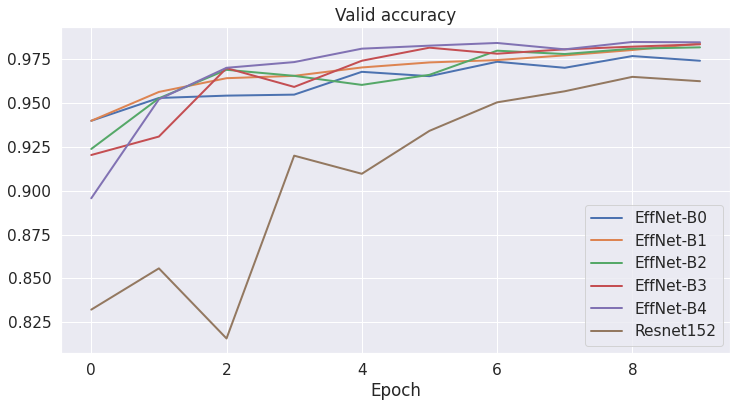

In [ ]:
# График валидационной accuracy.history при обучении моделей

sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(12, 6))
plt.title("Valid accuracy")
plt.plot(range(10), eval(df_accuracy['val'][0]), label="EffNet-B0", linewidth=2)
plt.plot(range(10), eval(df_accuracy['val'][1]), label="EffNet-B1", linewidth=2)
plt.plot(range(10), eval(df_accuracy['val'][2]), label="EffNet-B2", linewidth=2)
plt.plot(range(10), eval(df_accuracy['val'][3]), label="EffNet-B3", linewidth=2)
plt.plot(range(10), eval(df_accuracy['val'][4]), label="EffNet-B4", linewidth=2)
plt.plot(range(10), eval(df_accuracy['val'][5]), label="Resnet152", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

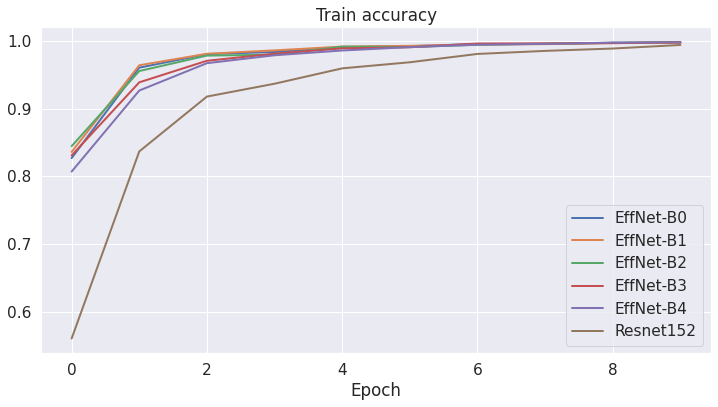

In [ ]:
# График accuracy.history на train-датасете при обучении моделей

sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(12, 6))
plt.title("Train accuracy")
plt.plot(range(10), eval(df_accuracy['train'][0]), label="EffNet-B0", linewidth=2)
plt.plot(range(10), eval(df_accuracy['train'][1]), label="EffNet-B1", linewidth=2)
plt.plot(range(10), eval(df_accuracy['train'][2]), label="EffNet-B2", linewidth=2)
plt.plot(range(10), eval(df_accuracy['train'][3]), label="EffNet-B3", linewidth=2)
plt.plot(range(10), eval(df_accuracy['train'][4]), label="EffNet-B4", linewidth=2)
plt.plot(range(10), eval(df_accuracy['train'][5]), label="Resnet152", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

## Комитет

Объединим информацию о предсказаниях всех шести моделей на тестовых данных. Создадим так называемый комитет, в котором будет выбираться наиболее часто встречающееся предсказание для каждого тестового изображения. Если все предсказания отличаются друг от друга, то выбирается решение модели EfficientNet-B4.

In [149]:
committee = pd.DataFrame()
committee_b0 = pd.read_csv(BASE_DIR/'simpsons_submit_b0.csv', header='infer', usecols=['Id','Expected'])
committee_b1 = pd.read_csv(BASE_DIR/'simpsons_submit_b1.csv', usecols=['Expected'])
committee_b2 = pd.read_csv(BASE_DIR/'simpsons_submit_b2.csv', usecols=['Expected'])
committee_b3 = pd.read_csv(BASE_DIR/'simpsons_submit_b3.csv', usecols=['Expected'])
committee_b4 = pd.read_csv(BASE_DIR/'simpsons_submit_b4.csv', usecols=['Expected'])
committee_r152 = pd.read_csv(BASE_DIR/'simpsons_submit_r152.csv', usecols=['Expected'])
committee['Id'] = committee_b0['Id'].copy()
committee['b0'] = committee_b0['Expected'].copy()
committee['b1'] = committee_b1['Expected'].copy()
committee['b2'] = committee_b2['Expected'].copy()
committee['b3'] = committee_b3['Expected'].copy()
committee['b4'] = committee_b4['Expected'].copy()
committee['r152'] = committee_r152['Expected'].copy()

In [158]:
expected = []
for _, data in committee[['b0','b1', 'b2', 'b3', 'b4', 'r152']].iterrows():
  if len(set(data.tolist())) != 6:
    expected.append(statistics.mode(data.tolist()))
  else:
    expected.append(data.tolist()[4])
committee['Expected'] = expected
committee = committee[['Id', 'Expected']]
committee.to_csv(BASE_DIR/'simpsons_submit_committee.csv', index=False)

# Данный метод улучшил Public Scor на Kaggle на 0,00425. Кажется, мелочь, но когда исходный Public Scor превышает 0.99 подобные изменения являются значимыми.

---

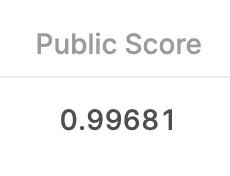

---

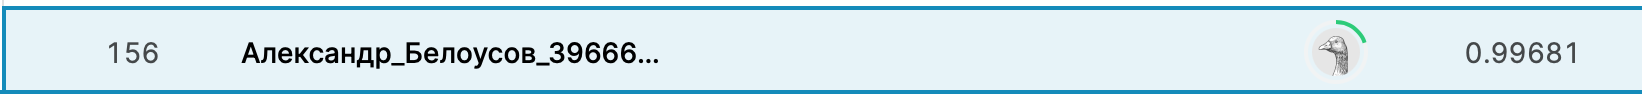

---

# Загрузка сохраненных весов, расчет f1-score

In [ ]:
model_name = 'efficientnet-b4'

model = initialize_model(model_name, feature_extract=False, use_pretrained=True).to(device)

rescale_size = EfficientNet.get_image_size(model_name)

val_dataset = SimpsonsDataset(val_files, mode='val', rescale_size=rescale_size)
new_train_dataset = SimpsonsDataset(
    new_train_files, mode='train', rescale_size=rescale_size)

model.load_state_dict(torch.load(
    Path(str(BASE_DIR) + str('/') + str(model_name))))
model.eval()

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(device)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
def predict_one_sample(model, img_tensor, device=device):
    with torch.no_grad():
        img_tensor = img_tensor.to(device)
        model.eval()
        y_hat = model(img_tensor).cpu()
        y_pred = torch.nn.functional.softmax(y_hat, dim=1).numpy()
    return y_pred

In [ ]:
def make_f1_score(model, n=len(val_dataset)):

    idxs = list(map(int, np.random.uniform(0, n, n)))
    imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

    probs_ims = predict(model, imgs)
    y_pred = np.argmax(probs_ims, -1)

    actual_labels = [val_dataset[id][1] for id in idxs]
    preds_class = list(y_pred)

    return round(f1_score(actual_labels, preds_class, average='micro'), 3).tolist()

In [ ]:
# Расчет f1_score на валидационном датасете
f1_val = make_f1_score(model)
f1_val

0.986

### Визуализация предсказаний

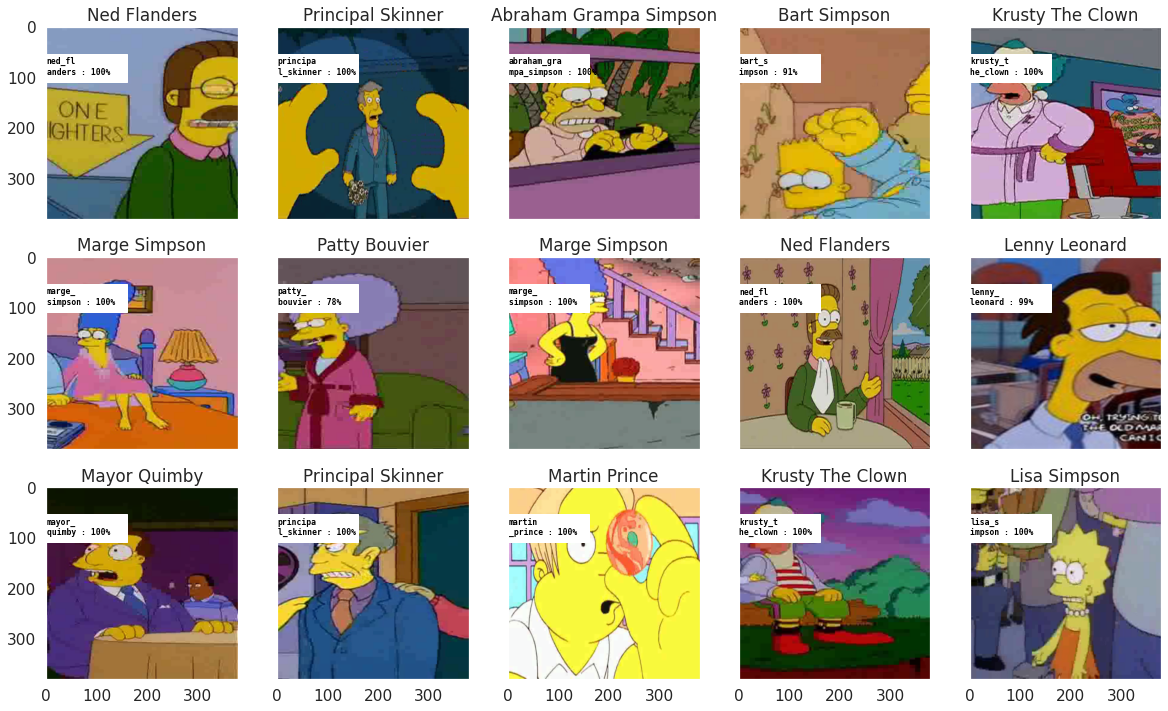

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(20, 12),
                       sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, 5000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),
                             val_dataset.label_encoder.inverse_transform([label])[0].split('_')))

    imshow(im_val.data.cpu(),
           title=img_label, plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53), 160, 55, color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("monospace")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(
        predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label, predicted_proba)

    fig_x.text(1, 59, predicted_text, horizontalalignment='left', fontproperties=font,
               verticalalignment='top', fontsize=8, color='black', fontweight='bold')

### Построим confusion matrix

In [ ]:
def confusion_matrix():
    # вытащим настоящие лейблы!
    actual = [val_dataset[i][1] for i in range(len(val_dataset))]
    
    # вытащим картинки, чтобы их подать в даталоадер, а потом классификатору
    image = [val_dataset[i][0] for i in range( len(val_dataset) ) ]
    
    # подготовим даталоадер
    img_conf_dataloader = torch.utils.data.DataLoader(image, batch_size=16, shuffle=False, num_workers=2)
    
    # вытащим предсказанные лейблы
    probs = predict(model, img_conf_dataloader)
    preds = np.argmax(probs, axis=1)
    
    # создадим таблицу, где в одном столбце будут нстоящие метки, во втором предсказанные
    df = pd.DataFrame({'actual': actual, 'preds': preds})
    
    # margins = False - чтобы не было строки all
    confusion_matrix = pd.crosstab(df['actual'], df['preds'], rownames=['Actual'], colnames=['Predicted'], margins = False)
    
    # загрузим наш инкодер
    label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
    
    # получим список классов
    # label_encoder.classes_[i] - можно убедиться, какому классу, какое кодированное число какому классу соответствует
    yticklabels = label_encoder.classes_
    
    plt.subplots(figsize=(20,20))

    sns.heatmap(confusion_matrix, annot=True, fmt="d", linewidths=0.5, cmap="YlGnBu", cbar=False, vmax = 30, yticklabels = yticklabels, xticklabels = yticklabels);

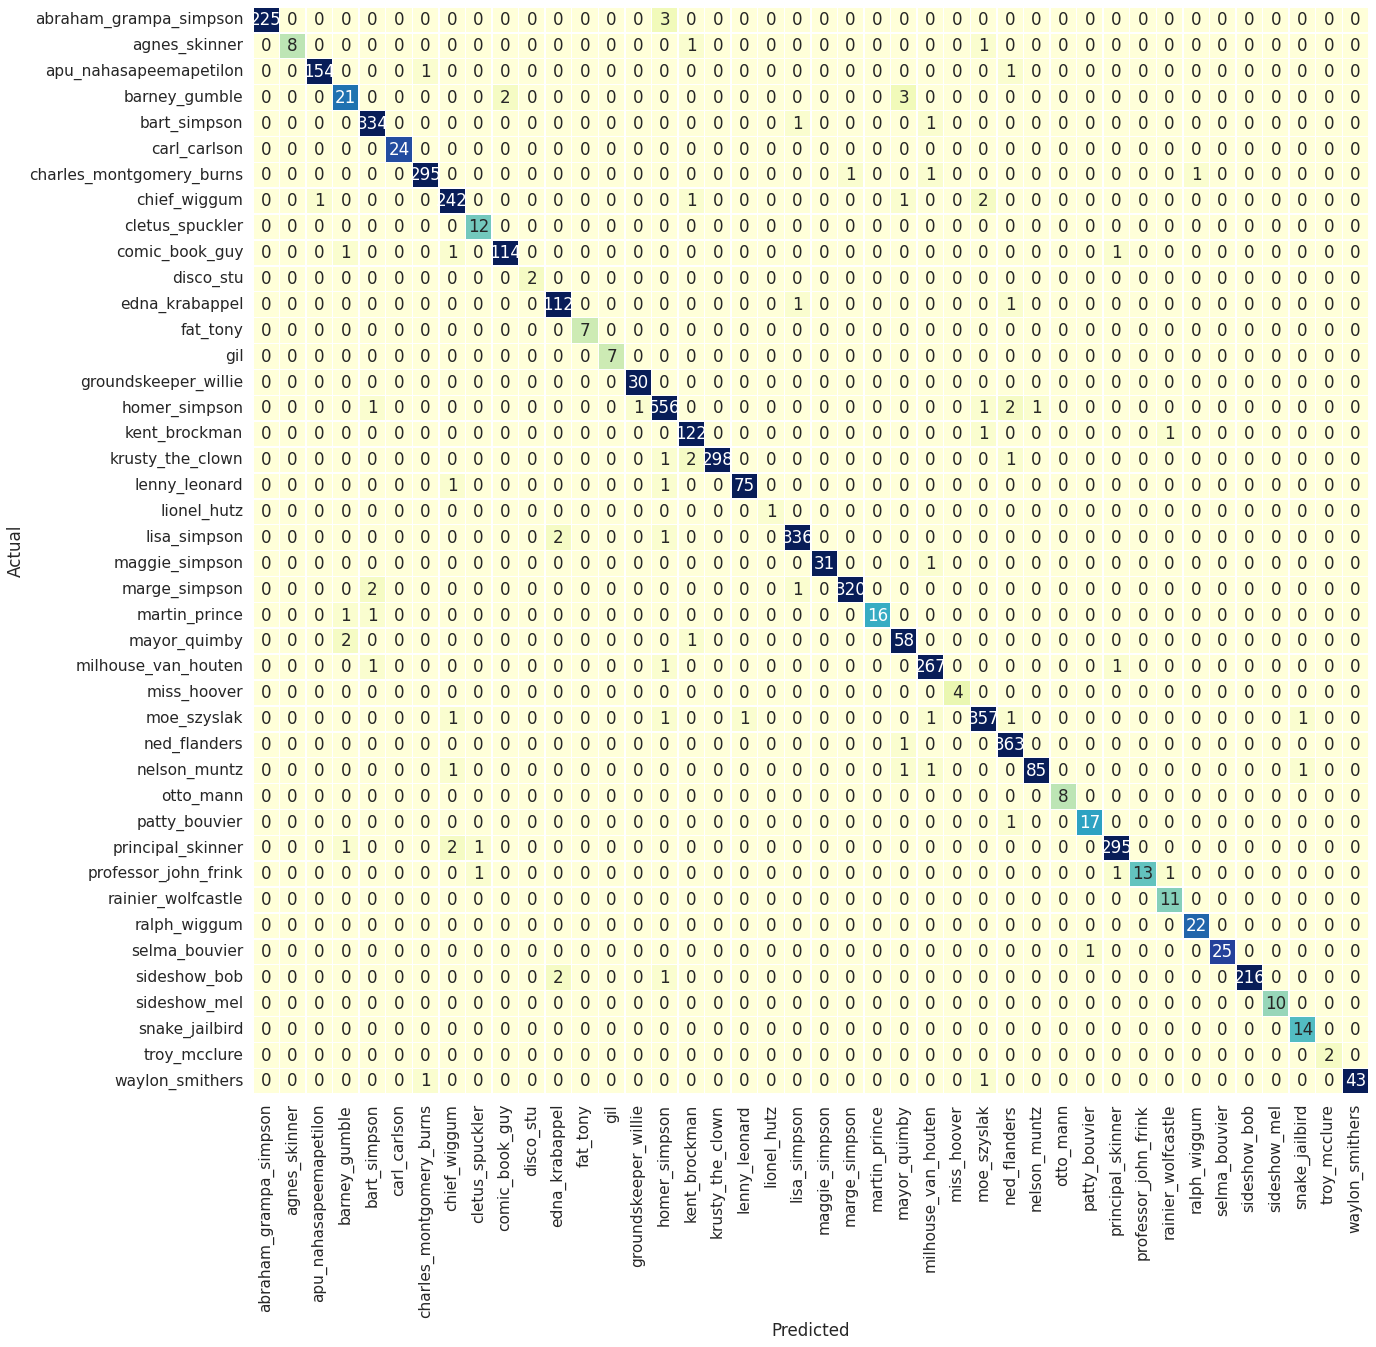

In [ ]:
confusion_matrix()

# Submit на Kaggle

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test", rescale_size=rescale_size)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
my_submit.to_csv(BASE_DIR/'simpsons_submit.csv', index=False)

---

# К О Н Е Ц !

---